# Cotton Imaging Mask R-CNN Model

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch.cuda.empty_cache()

torch:  1.9 ; cuda:  cu111


In [2]:
# Some basic setup:
# Setup detectron2 logger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

# import some common libraries
import numpy as np
import os, json, cv2, random

import fiftyone as fo
from PIL import Image

In [3]:
import logging

from detectron2 import model_zoo
from detectron2.model_zoo import get_config
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.config import LazyCall as L
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_argument_parser,
    default_setup,
    default_writers,
    hooks,
    launch,
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import detectron2

logger = logging.getLogger("detectron2")

In [4]:
def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        print_csv_format(ret)
        return ret

In [5]:
def do_train(cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=False)
    if False and checkpointer.has_checkpoint():
        # The checkpoint stores the training iteration that just finished, thus we start
        # at the next iteration
        start_iter = trainer.iter + 1
    else:
        start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

In [6]:
register_coco_instances("CottonImaging_train", {}, '/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TrainingSet_Dataset070422.json', "/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/training_images")

register_coco_instances("CottonImaging_test", {}, "/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TestSet_Dataset070422.json", "/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/test_images")

Loaded 63 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TestSet_Dataset070422.json


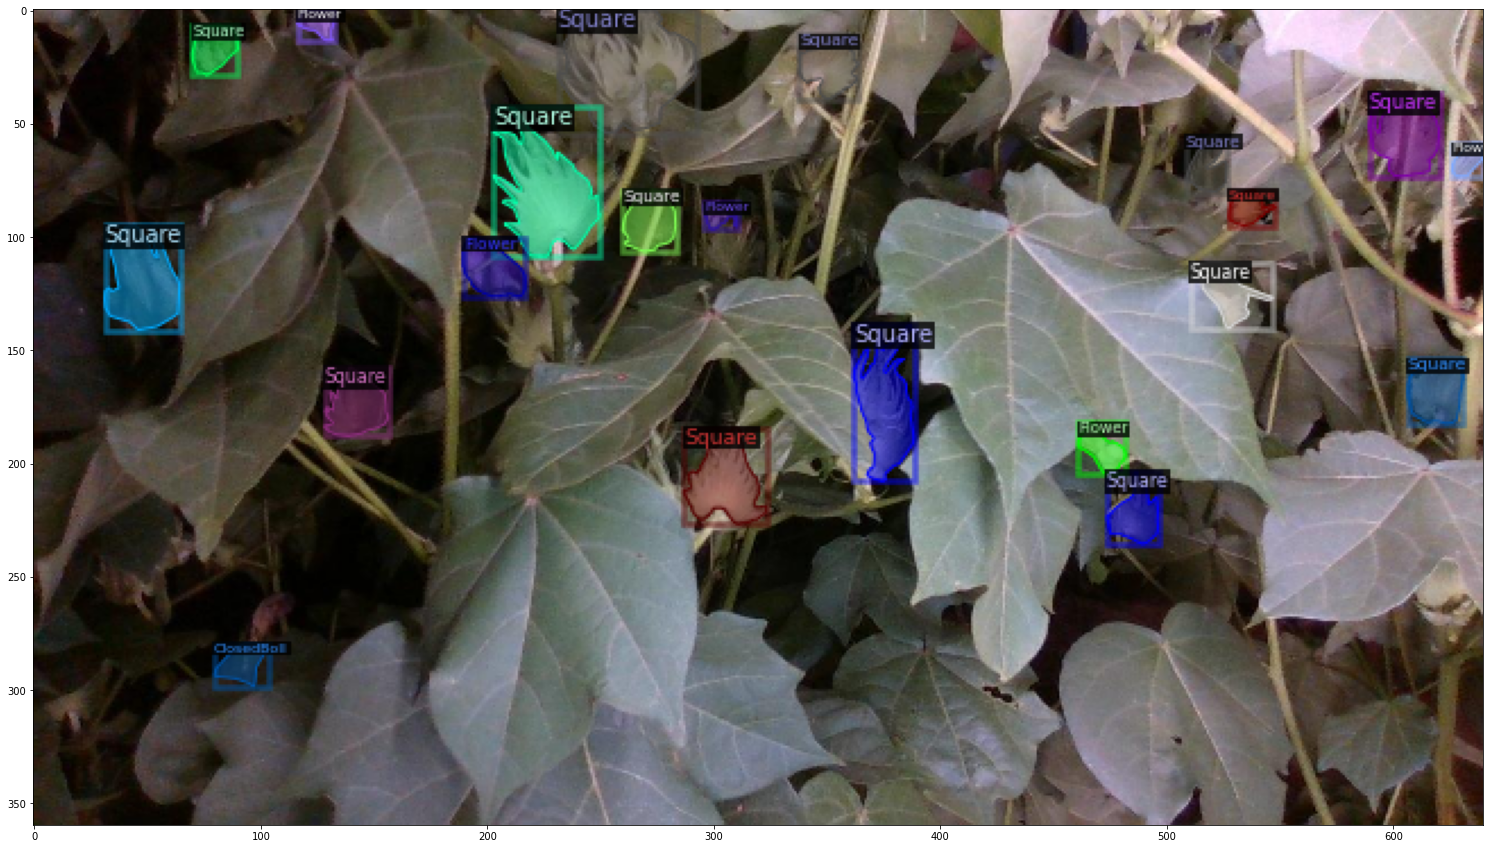

In [7]:
from detectron2.utils.visualizer import Visualizer

metadata_test = MetadataCatalog.get("CottonImaging_test")
dataset_dicts = DatasetCatalog.get("CottonImaging_test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_test, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Training

In [7]:
def cfg2yaml(cfg):
    
    with open(cfg.train.output_dir + "/Config.txt", 'w') as file:
        file.write(str(cfg))
    
    os.rename(cfg.train.output_dir + "/Config.txt", cfg.train.output_dir + "/Config.yaml")

In [8]:
args = {
    "config_file":"new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py",
    "eval_only":"False"
}

cfg = get_config("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py")
cfg.model.backbone.bottom_up.stages = detectron2.modeling.ResNet.make_default_stages(depth=50, norm='BN', stride_in_1x1=True)
cfg.model.backbone.norm = "BN"
cfg.model.backbone.bottom_up.stem = detectron2.modeling.backbone.BasicStem(in_channels=3, norm='BN', out_channels=64)
cfg.dataloader.train.dataset = L(detectron2.data.get_detection_dataset_dicts)(names='CottonImaging_train')
cfg.dataloader.test.dataset = L(detectron2.data.get_detection_dataset_dicts)(names='CottonImaging_test')
cfg.train.max_iter=20000
cfg.train.eval_period = 200
cfg.train.init_checkpoint= model_zoo.get_checkpoint_url("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py")
cfg.train.output_dir='/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/Training/New Baseline Models/07_15_2022_20000iter'
cfg.model.roi_heads.num_classes = 4
# cfg.model.proposal_generator.nms_thresh = 0.6
cfg.optimizer.lr=0.00015
cfg.lr_multiplier.scheduler.milestones = [15000, 19000]
cfg.lr_multiplier.scheduler.values = [1.0, 0.1, 0.01]
cfg.lr_multiplier.scheduler.num_updates = 20000
cfg.dataloader.train.total_batch_size = 12
cfg.train.checkpointer.period = 2500
# cfg = LazyConfig.apply_overrides(cfg, args.opts)
os.makedirs(cfg.train.output_dir, exist_ok=True)

# default_setup(args, cfg)
# cfg2yaml(cfg)

# do_train(cfg)

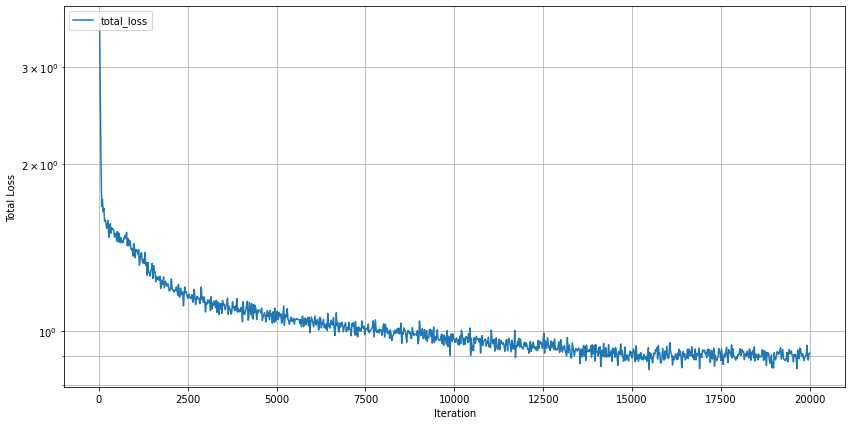

In [9]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(cfg.train.output_dir + '/metrics.json')
plt.grid(True, which="both")
plt.semilogy(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.legend(['total_loss'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.savefig(cfg.train.output_dir +  '/Loss Curve.png')
plt.show()

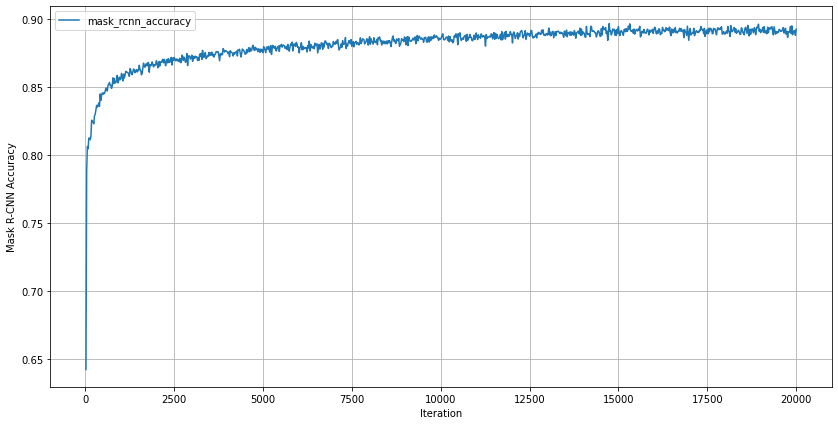

In [10]:
plt.grid(True, which="both")
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], 
    [x['mask_rcnn/accuracy'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x])
plt.legend(['mask_rcnn_accuracy'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Mask R-CNN Accuracy')
plt.savefig(cfg.train.output_dir + '/mask_rcnn_accuracy_Curve.png')
plt.show()

# Testing and Inference

## Testing

In [24]:
cfg.train.init_checkpoint = cfg.train.output_dir + '/model_final.pth'
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.65
model = instantiate(cfg.model)
model.to(cfg.train.device)
model = create_ddp_model(model)
DetectionCheckpointer(model).load(cfg.train.init_checkpoint)

ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )

model.eval()


[Checkpointer] Loading from /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/Training/New Baseline Models/07_15_2022_20000iter/model_final.pth ...
Loaded 63 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TestSet_Dataset070422.json
Removed 0 images with no usable annotations. 63 images left.
[DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333)]
Serializing 63 elements to byte tensors and concatenating them all ...
Serialized dataset takes 1.44 MiB
Start inference on 63 batches
Inference done 11/63. Dataloading: 0.0006 s/iter. Inference: 0.0871 s/iter. Eval: 0.0492 s/iter. Total: 0.1369 s/iter. ETA=0:00:07
Inference done 55/63. Dataloading: 0.0008 s/iter. Inference: 0.0858 s/iter. Eval: 0.0311 s/iter. Total: 0.1178 s/iter. ETA=0:00:00
Total inference time: 0:00:06.926223 (0.119418 s / iter per device, on 1 devices)
Total inference pure compute time: 0:00:04 (0.085913 s / iter per d

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [25]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("CottonImaging_test", output_dir=cfg.train.output_dir,use_fast_impl=False)
val_loader = instantiate(cfg.dataloader.test)
print(inference_on_dataset(model, val_loader, evaluator))

Loaded 63 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TestSet_Dataset070422.json
Removed 0 images with no usable annotations. 63 images left.
[DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333)]
Serializing 63 elements to byte tensors and concatenating them all ...
Serialized dataset takes 1.44 MiB
Start inference on 63 batches
Inference done 26/63. Dataloading: 0.0008 s/iter. Inference: 0.0890 s/iter. Eval: 0.0355 s/iter. Total: 0.1253 s/iter. ETA=0:00:04
Total inference time: 0:00:07.005985 (0.120793 s / iter per device, on 1 devices)
Total inference pure compute time: 0:00:05 (0.087255 s / iter per device, on 1 devices)
Preparing results for COCO format ...
Saving results to /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/Training/New Baseline Models/07_15_2022_20000iter/coco_instances_results.json
Evaluating predictions with official COCO API...
Loading and preparing res

In [11]:
cfg.train.checkpointer.period

5000

## Inference for Visualization

In [13]:
from detectron2.data import detection_utils as utils
import copy
import torch
 # Show how to implement a minimal mapper, similar to the default DatasetMapper
def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    dicts = []
    for i in range(len(dataset_dict)):
        image = utils.read_image(dataset_dict[i]["file_name"], format="BGR")
        temp = image.copy()
        utils.check_image_size(dataset_dict[i], temp)
        temp = np.moveaxis(temp, -1, 0)
        image = torch.from_numpy(temp)
        dicts.append({
           "image": image,
           'height': 720,
           'width': 1280,
        })
    return dicts

In [ ]:
dataset_dict = detectron2.data.get_detection_dataset_dicts('CottonImaging_test')
data= mapper(dataset_dict)

outputs = []
for i in range(len(data)):
    with torch.no_grad():
     outputs = outputs + model([data[i]])


In [ ]:
for dictionary in dataset_dict:
    tail, head = os.path.split(dataset_dict['file_name'])
    depth = tail + '/Depth/' + head[:head.rfind('.')] + '.png'
    print(depth)

In [11]:
type(dataset_dict)

list

# FiftyOne Visualization

In [26]:
dataset.delete()
dataset = fo.Dataset.from_dir(
    data_path= "/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/test_images",
    labels_path='/home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TestSet_Dataset070422.json',
    dataset_type=fo.types.COCODetectionDataset,
    label_types=["detections", "segmentations"],
    label_field = "ground_truth",
    #name="Model_2500_1024BatchSize_15LR"
)

#View summary info about the dataset
print(dataset)

 100% |███████████████████| 63/63 [2.9s elapsed, 0s remaining, 24.2 samples/s]      
Name:        2022.07.16.21.28.36
Media type:  image
Num samples: 63
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Get class list
#classes = dataset.default_classes
classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]
# PATH = '/home/avl/Projects/Cotton Imaging Project/Data/Datasets02272022/7030_images/Training/Base Model/Predictions/TestingSet Masks/'

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        i = 1
        # Load image
        image = cv2.imread(sample.filepath)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w , c = image.shape
        temp = image.copy()
        temp = np.moveaxis(temp, -1, 0)
        image = torch.from_numpy(temp)
        dict_input = {
           "image": image,
           'height': 720,
           'width': 1280,
        }
        # Perform inference
        preds = model([dict_input])
        preds = preds[0]
        labels = preds["instances"].pred_classes.cpu().detach().numpy()
        scores = preds["instances"].scores.cpu().detach().numpy()
        #boxes = preds["instances"].pred_boxes.tensor.cpu().detach().numpy()
        masks = preds["instances"].pred_masks.cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        segmentations = []
#        for label, score, box, seg in zip(labels, scores, boxes, masks):
        for label, score, seg in zip(labels, scores, masks):
        
            # Generate images for each mask
#             cv2.imwrite(PATH+sample.filepath[sample.filepath.rfind('/')+1:-4]
#                         + f"_{i}_" + classes[label] + ".png", seg * 255)
            i += 1
            
            if score > 0.1:
                segmentations.append(
                    fo.Detection.from_mask(
                        mask=seg,
                        label=classes[label],
                        confidence=score
                        )
                    )

        # Save predictions to dataset
#         sample["predictions"] = fo.Detections(detections=detections)
        sample["predictions"] = fo.Detections(detections=segmentations)
        sample.save()

print("Finished adding predictions")

 100% |███████████████████| 63/63 [8.9s elapsed, 0s remaining, 7.4 samples/s]       
Finished adding predictions


In [28]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    eval_key="eval",
    compute_mAP=True,
    use_masks=True,
    classes= classes,
    iou=0.5,
)


Evaluating detections...
   0% ||------------------|  0/63 [35.0ms elapsed, ? remaining, ? samples/s] 

/home/avl/.local/lib/python3.8/site-packages/fiftyone/utils/eta.py:946: UserWarning: Ignoring unsupported attribute type '<class 'mongoengine.base.datastructures.BaseList'>'
  warnings.warn(msg)


 100% |███████████████████| 63/63 [10.4s elapsed, 0s remaining, 6.0 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 63/63 [11.8s elapsed, 0s remaining, 5.5 samples/s]      


In [29]:
results.print_report()

              precision    recall  f1-score   support

    OpenBoll       0.79      0.79      0.79       484
  ClosedBoll       0.75      0.73      0.74       644
      Flower       0.78      0.68      0.73       278
      Square       0.65      0.72      0.69       595

   micro avg       0.73      0.73      0.73      2001
   macro avg       0.74      0.73      0.73      2001
weighted avg       0.73      0.73      0.73      2001



In [23]:
session = fo.launch_app(dataset)

ValueError: Dataset '2022.07.16.21.25.19' is deleted

In [16]:
session.close()

In [80]:
# Export the dataset GTseg
dataset.export(
    labels_path= cfg.train.output_dir + "/GTsegmentation_testing_0550.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "ground_truth_segmentations",
)

# Export the dataset predictions
dataset.export(
    labels_path= cfg.train.output_dir + "/predictions_testing_0550.json" ,
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "predictions",
)

   0% ||------------------|  0/63 [64.1ms elapsed, ? remaining, ? samples/s] 

/home/avl/.local/lib/python3.8/site-packages/fiftyone/utils/eta.py:946: UserWarning: Ignoring unsupported attribute type '<class 'mongoengine.base.datastructures.BaseList'>'
  warnings.warn(msg)


 100% |███████████████████| 63/63 [19.1s elapsed, 0s remaining, 3.6 samples/s]      
 100% |███████████████████| 63/63 [32.4s elapsed, 0s remaining, 2.0 samples/s]      


In [30]:
session = fo.launch_app(dataset)